## xgboost모델 돌리고 개수 맞추기까지 적혀있는 코드입니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn import preprocessing


from tqdm import tqdm

/home/ubuntu/anaconda3/envs/py38mj/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
industry_data_1_add0 = pd.read_csv('./dataset_new/industry_data_add0.csv')

In [3]:
# 제출 형식에 맞게 정렬
industry_data_1_add0.sort_values(['Datetime','Store','Item'],inplace=True)
industry_data_1_add0.reset_index(drop=True,inplace=True)
#industry_data_1_add0

In [4]:
# Label encoding

label = preprocessing.LabelEncoder()
industry_data_encoded = pd.DataFrame()

industry_data_1_col = ['Product Type', 'Item', 'Region Level 1', 'Region Level 2', 'Urban/Rural']
for i in industry_data_1_add0.columns:
    if i in industry_data_1_col:
        industry_data_encoded[i] = label.fit_transform(industry_data_1_add0[i])
    else:
        industry_data_encoded[i] = industry_data_1_add0[i]

In [5]:
industry_data_encoded.head()

,Industry Size,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural,Owner,quarter
0,0,1,2,0,2015,1,2015-01-01,31,9,1,1,1
1,0,1,2,1,2015,1,2015-01-01,31,9,1,1,1
2,0,1,1,2,2015,1,2015-01-01,31,9,1,1,1
3,0,1,0,3,2015,1,2015-01-01,31,9,1,1,1
4,0,1,1,4,2015,1,2015-01-01,31,9,1,1,1


In [6]:
# 예측할 구간 선택
set_dt_list = ['2022-04-01','2022-05-01','2022-06-01']

In [7]:
for set_dt in set_dt_list:
   train_1 = industry_data_encoded[industry_data_encoded['Datetime'] < set_dt]
   val_1 = industry_data_encoded[(industry_data_encoded['Datetime'] >= set_dt)]

   # Feature와 Target 분리
   target = 'Industry Size'
   features = train_1.drop([target,"Datetime",'quarter','Region Level 1', 'Region Level 2'], axis=1).columns

   X_train = train_1[features]
   y_train = train_1[target]
   X_val = val_1[features]
   y_val = val_1[target]

   print(X_train.shape, y_train.shape)
   print(X_val.shape, y_val.shape)

   # 파이프라인 생성 및 학습
   xgb_basic = make_pipeline(
      SimpleImputer(),
      RobustScaler(),
      XGBRegressor(random_state=1,
                  n_jobs=-1,
                  objective='reg:squarederror',
                  max_depth=5, 
                  learning_rate=0.2, 
                     )
                  )

   xgb_basic.fit(X_train, y_train);

   # 예측
   y_pred = xgb_basic.predict(X_val)

   # prediction값 반올림
   y_pred_r =  [round(x) if round(x) >=0 else 0 for x in y_pred]

   # 결과 확인

   print('mae:  ', mae(y_val, y_pred_r))
   print('rmse: ', np.sqrt(mse(y_val, y_pred_r)))
   

   # RMSE는 MAE에 비해 직관성은 떨어지지만 Robust한 성격(극단적이지 않은 성격)에서 강점을 보인다.

   newlist = list(industry_data_encoded[industry_data_encoded['Datetime']<set_dt]['Industry Size'])+y_pred_r
   industry_data_encoded['Industry Size'] = newlist

   '''
   (1005372, 7) (1005372,)
(34668, 7) (34668,)
mae:   1.1522441444559826
rmse:  1.7096735745150142
(1016928, 7) (1016928,)
(23112, 7) (23112,)
mae:   0.11673589477327795
rmse:  0.341919530064906
(1028484, 7) (1028484,)
(11556, 7) (11556,)
mae:   0.12287988923502942
rmse:  0.3537369117011909
   '''

(1005372, 7) (1005372,)
(34668, 7) (34668,)
mae:   1.1522441444559826
rmse:  1.7096735745150142
(1016928, 7) (1016928,)
(23112, 7) (23112,)
mae:   0.11673589477327795
rmse:  0.341919530064906
(1028484, 7) (1028484,)
(11556, 7) (11556,)
mae:   0.12287988923502942
rmse:  0.3537369117011909


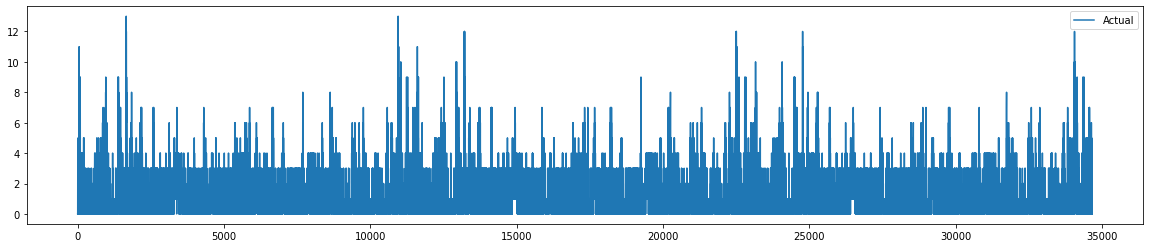

In [8]:
plt.figure(figsize=(20, 4))

plt.plot(industry_data_encoded[industry_data_encoded['Datetime'] >= set_dt_list[0]]['Industry Size'].reset_index(drop=True), label='Actual',)
#plt.plot(y_pred_r, label='Predicted')



plt.legend()
plt.show();

In [9]:
set_dt_list[0]

'2022-04-01'

In [10]:
result = pd.DataFrame([])
result['predicted'] = industry_data_encoded[industry_data_encoded['Datetime'] >= set_dt_list[0]]['Industry Size'].reset_index(drop=True)

In [645]:
# 4+5+6월
sum_456 = result[:11556].copy()
for i in range(len(sum_456)):
    m_5 = result.loc[i+11556]['predicted']
    m_6 = result.loc[i+11556+11556]['predicted']
    sum_456.loc[i,'predicted'] = sum_456.loc[i,'predicted'] + m_5 + m_6
    

In [646]:
sum_456

,predicted
0,0
1,0
2,3
3,7
4,3
...,...
11551,9
11552,3
11553,8
11554,4


In [647]:
sum_456['predicted'].sum()

39946

In [800]:
zerofile = pd.read_csv(f"example_allocation_result_file00.csv")

In [801]:
zerofile['Allocation'] = sum_456['predicted']

In [802]:
zerofile

,Store,Item,Allocation
0,1,Bracket,0
1,1,Brush,0
2,1,Cereal,3
3,1,Ear Buds,7
4,1,Eggs,3
...,...,...,...
11551,642,Phone Charger,9
11552,642,Power Cord,3
11553,642,Shrimp,8
11554,642,Steak,4


In [803]:
zerofile['Allocation'].sum()

39946

In [804]:
zerofile['Allocation'].max()

37

In [807]:
check1 = []
divided = []
for i in range(len(zerofile)):
    now_num = zerofile.loc[i]['Allocation']


    # 0으로 만들 값 체크
    #zerolist = ['Milk','Tape','Nails']#,'Eggs','Cereal']#,"Brush","Bracket"]
    zerolist = ['Nails','Milk','Tape','Bracket','Eggs']#, 'Brush','Glue']#,'Power Cord','Noodles']#,'Ear Buds'] # 가격순
    clist = ['Milk','Tape','Nails','Eggs','Cereal']#,"Brush","Bracket",]

    if zerofile.loc[i]['Item'] in zerolist:
        divided.append(0)
        continue # 아래 실행 x
    
    #clist
    if zerofile.loc[i]['Item'] in clist:
        if now_num>30:
            divided.append(round(now_num/3))
        elif now_num > 20:
            divided.append(round(now_num/4))
        elif now_num > 10:
            divided.append(round(now_num/5))
        elif now_num > 5:
            divided.append(round(now_num/6))
            
        else:
            divided.append(0)
        continue

    # 1보다 큰지 체크
    if now_num>=1:
        check1.append(1)
    else:
        check1.append(0)



    # 값 체크
    if now_num>30:
        divided.append(round(now_num/2))
    elif now_num > 20:
        divided.append(round(now_num/2.3))
    elif now_num > 10:
        divided.append(round(now_num/2.7))
    elif now_num > 5:
        divided.append(round(now_num/4.05))

    elif now_num>=1:
        divided.append(1)
    else:
        divided.append(0)


In [808]:
sum(divided)

9834

In [795]:
zerofile['Allocation'] = divided

In [ ]:
zerofile[(zerofile['Item']=='King Crab')&(zerofile['Allocation']>10)]

In [799]:
# zerofile.loc[1659,'Allocation']=4
# zerofile.loc[10947,'Allocation']=4

# #10k
zerofile.loc[1663,'Allocation']=8
zerofile.loc[10951,'Allocation']=7
zerofile.loc[3121,'Allocation']=6
zerofile.loc[9871,'Allocation']=5
zerofile.loc[655,'Allocation']=5
zerofile.loc[3301,'Allocation']=5

In [785]:
zeroking = zerofile[(zerofile['Item']=='King Crab')&(zerofile['Allocation']==0)].index

In [658]:
for i in zeroking:
    zerofile.loc[i,'Allocation']=1

In [660]:
onekey = zerofile[(zerofile['Item']=='Keyboard')&(zerofile['Allocation']==1)].index

In [661]:
onekey

Int64Index([  132,   186,   222,   294,   312,   348,   402,   420,   438,
              492,
            ...
            11148, 11166, 11184, 11310, 11328, 11382, 11418, 11472, 11490,
            11508],
           dtype='int64', length=261)

In [666]:
for i in onekey[-143:]:
    zerofile.loc[i,'Allocation']=2

In [667]:
zerofile['Allocation'].sum()

10000

In [668]:
zerofile

,Store,Item,Allocation
0,1,Bracket,0
1,1,Brush,0
2,1,Cereal,0
3,1,Ear Buds,2
4,1,Eggs,0
...,...,...,...
11551,642,Phone Charger,2
11552,642,Power Cord,1
11553,642,Shrimp,2
11554,642,Steak,1


In [783]:
zerofile.to_csv(f"example_allocation_result_file_10k_1217_7.csv", index=False)
# industry_data.to_csv(f"{file_path}Industry_data_add_region.csv", index=False)
